# Environment Setup

To ensure the environment is correctly set up, follow these steps to download the dataset and install any necessary non-standard libraries.

## Libraries Set Up

In [97]:
 ! pip install -q kaggle

## Dataset Set Up


In [98]:
kaggle_json = {"username": "yijuli52", "key": "fe29da176c7e73aa458e22be06340fe4"}

import json
with open('kaggle.json', 'w') as file:
    json.dump(kaggle_json, file)

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [99]:
!ls

dataset  kaggle.json  labeled-optical-coherence-tomography-oct.zip  sample_data


In [100]:
!ls 'Dataset - train+val+test'

ls: cannot access 'Dataset - train+val+test': No such file or directory


In [101]:
!ls kaggle.json

kaggle.json


In [102]:
!kaggle datasets download -d anirudhcv/labeled-optical-coherence-tomography-oct

Dataset URL: https://www.kaggle.com/datasets/anirudhcv/labeled-optical-coherence-tomography-oct
License(s): unknown
labeled-optical-coherence-tomography-oct.zip: Skipping, found more recently modified local copy (use --force to force download)


In [103]:
!unzip labeled-optical-coherence-tomography-oct.zip

Streaming output truncated to the last 5000 lines.
  inflating: Dataset - train+val+test/val/NORMAL/NORMAL-5822041-15.jpeg  
  inflating: Dataset - train+val+test/val/NORMAL/NORMAL-5822041-16.jpeg  
  inflating: Dataset - train+val+test/val/NORMAL/NORMAL-5822041-18.jpeg  
  inflating: Dataset - train+val+test/val/NORMAL/NORMAL-5822041-2.jpeg  
  inflating: Dataset - train+val+test/val/NORMAL/NORMAL-5822041-8.jpeg  
  inflating: Dataset - train+val+test/val/NORMAL/NORMAL-582215-6.jpeg  
  inflating: Dataset - train+val+test/val/NORMAL/NORMAL-582215-7.jpeg  
  inflating: Dataset - train+val+test/val/NORMAL/NORMAL-582215-8.jpeg  
  inflating: Dataset - train+val+test/val/NORMAL/NORMAL-5823731-1.jpeg  
  inflating: Dataset - train+val+test/val/NORMAL/NORMAL-5823731-5.jpeg  
  inflating: Dataset - train+val+test/val/NORMAL/NORMAL-5824080-5.jpeg  
  inflating: Dataset - train+val+test/val/NORMAL/NORMAL-5824080-6.jpeg  
  inflating: Dataset - train+val+test/val/NORMAL/NORMAL-5830194-10.jpeg  

# Data Exploration

In [104]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from collections import Counter
import seaborn as sns

In [105]:
!ls

 dataset		     kaggle.json				    sample_data
'Dataset - train+val+test'   labeled-optical-coherence-tomography-oct.zip


In [108]:
!mv 'Dataset - train+val+test' dataset
dataset_path = 'dataset'

mv: cannot stat 'Dataset - train+val+test': No such file or directory


In [109]:
!ls

dataset  kaggle.json  labeled-optical-coherence-tomography-oct.zip  sample_data


In [110]:
!ls

dataset  kaggle.json  labeled-optical-coherence-tomography-oct.zip  sample_data


In [111]:
!ls 'Dataset - train+val+test'/test

ls: cannot access 'Dataset - train+val+test/test': No such file or directory


## About the Dataset: Classes

Number of images: 218618
Number of classes: 4
Class distribution: Counter({'NORMAL': 102780, 'CNV': 74910, 'DME': 23196, 'DRUSEN': 17732})


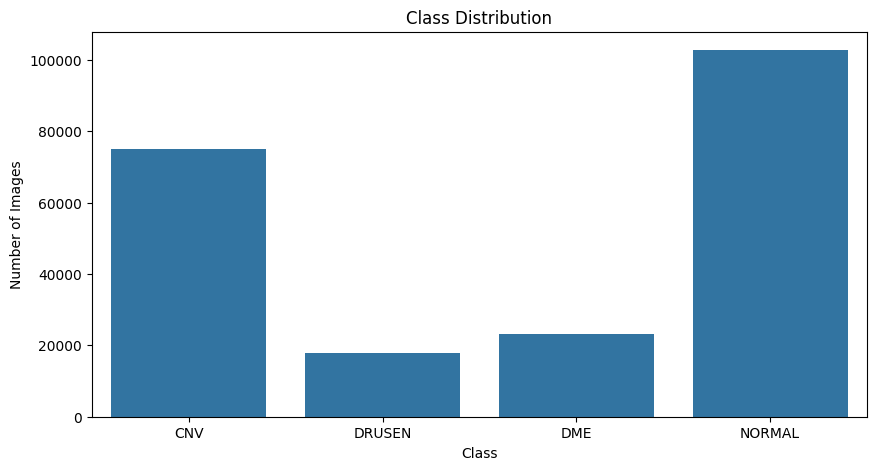

In [112]:
def get_image_paths_and_labels(dataset_path):
    image_paths = []
    labels = []
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.jpeg'):
                image_paths.append(os.path.join(root, file))
                labels.append(root.split(os.path.sep)[-1])
    return image_paths, labels

image_paths, labels = get_image_paths_and_labels(dataset_path)

num_images = len(image_paths)
num_classes = len(set(labels))

print(f"Number of images: {num_images}")
print(f"Number of classes: {num_classes}")

class_distribution = Counter(labels)
print(f"Class distribution: {class_distribution}")

plt.figure(figsize=(10, 5))
sns.barplot(x=list(class_distribution.keys()), y=list(class_distribution.values()))
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

## About the Dataset: Examples

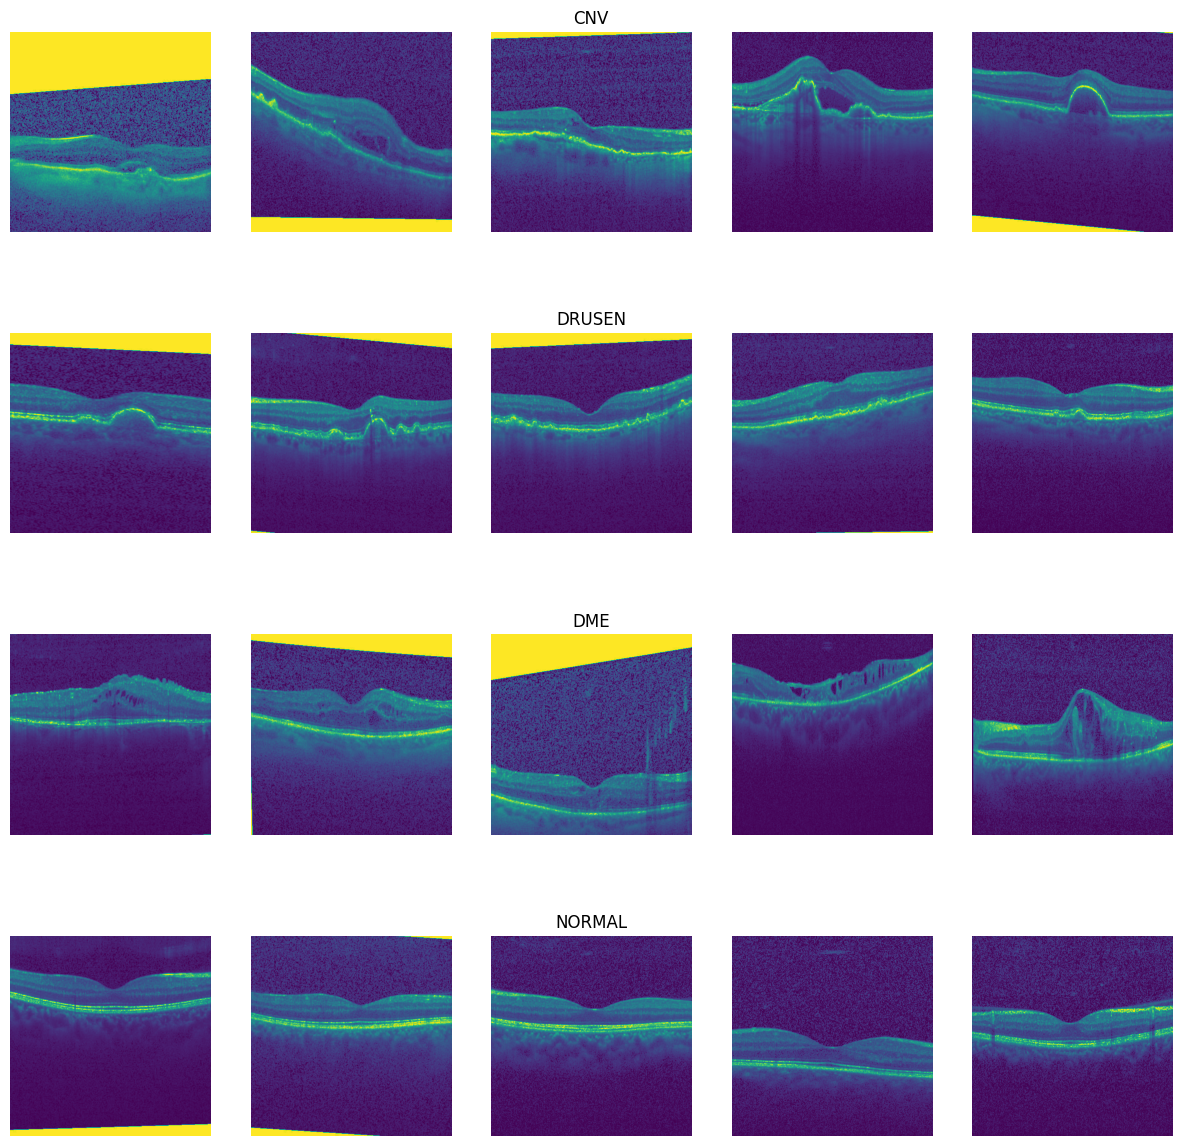

In [113]:
def plot_example_images(image_paths, labels, class_distribution, num_examples=5):
    plt.figure(figsize=(15, 15))
    for i, cls in enumerate(class_distribution.keys()):
        cls_images = [image_paths[j] for j in range(len(image_paths)) if labels[j] == cls]
        for j in range(num_examples):
            img = Image.open(cls_images[j])
            plt.subplot(len(class_distribution), num_examples, i * num_examples + j + 1)
            plt.imshow(img)
            plt.axis('off')
            if j == num_examples // 2:
                plt.title(cls)
    plt.show()

plot_example_images(image_paths, labels, class_distribution)

In [114]:
image_sizes = [Image.open(img_path).size for img_path in image_paths]

Image size distribution:
Size: (496, 496), Count: 109286
Size: (56, 496), Count: 21
Size: (496, 21), Count: 1
Size: (496, 110), Count: 1
Size: (512, 496), Count: 58037
Size: (768, 496), Count: 29749
Size: (1536, 496), Count: 11512
Size: (384, 496), Count: 21
Size: (1024, 496), Count: 1329
Size: (512, 512), Count: 8659
Size: (900, 455), Count: 1
Size: (642, 277), Count: 1


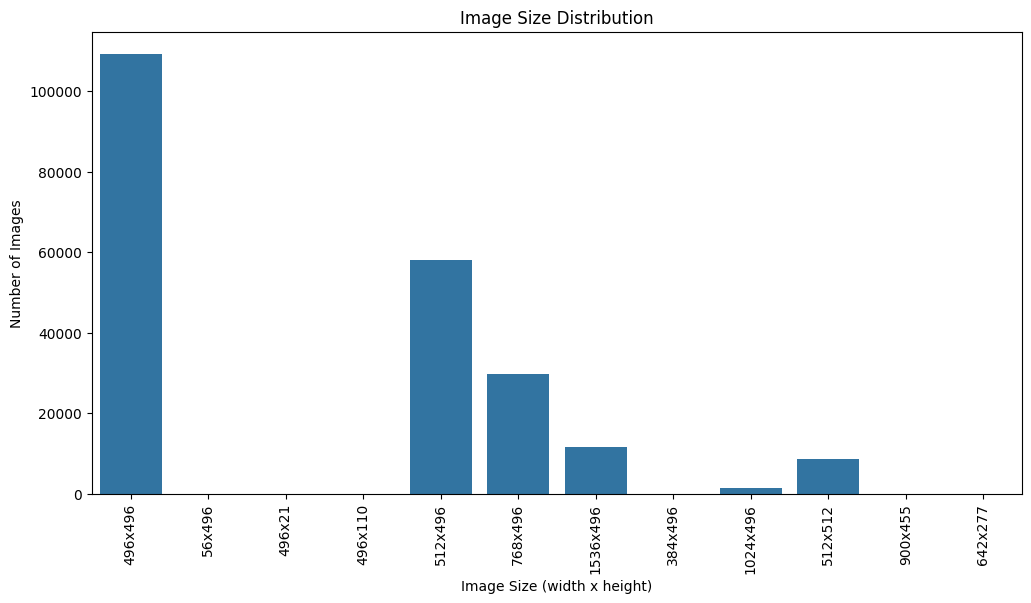

In [115]:
size_distribution = Counter(image_sizes)

print("Image size distribution:")
for size, count in size_distribution.items():
    print(f"Size: {size}, Count: {count}")

plt.figure(figsize=(12, 6))
sizes, counts = zip(*size_distribution.items())
sizes = [f"{size[0]}x{size[1]}" for size in sizes]  # Format sizes as strings
sns.barplot(x=sizes, y=counts)
plt.title('Image Size Distribution')
plt.xlabel('Image Size (width x height)')
plt.ylabel('Number of Images')
plt.xticks(rotation=90)
plt.show()

# Preprocessing

## Crop

In [116]:
from tqdm import tqdm

def crop_center(img, cropx, cropy):
    y, x = img.shape[0], img.shape[1]
    startx = x // 2 - (cropx // 2)
    starty = y // 2 - (cropy // 2)
    return img[starty:starty+cropy, startx:startx+cropx]

target_size = (496, 496)

def preprocess_images(image_paths, target_size):
    for img_path in tqdm(image_paths, desc="Processing images"):
        img = Image.open(img_path)
        img = np.array(img)
        img = crop_center(img, *target_size)
        img = Image.fromarray(img)
        img.save(img_path)

preprocess_images(image_paths, target_size)


Processing images: 100%|██████████| 218618/218618 [19:01<00:00, 191.59it/s]


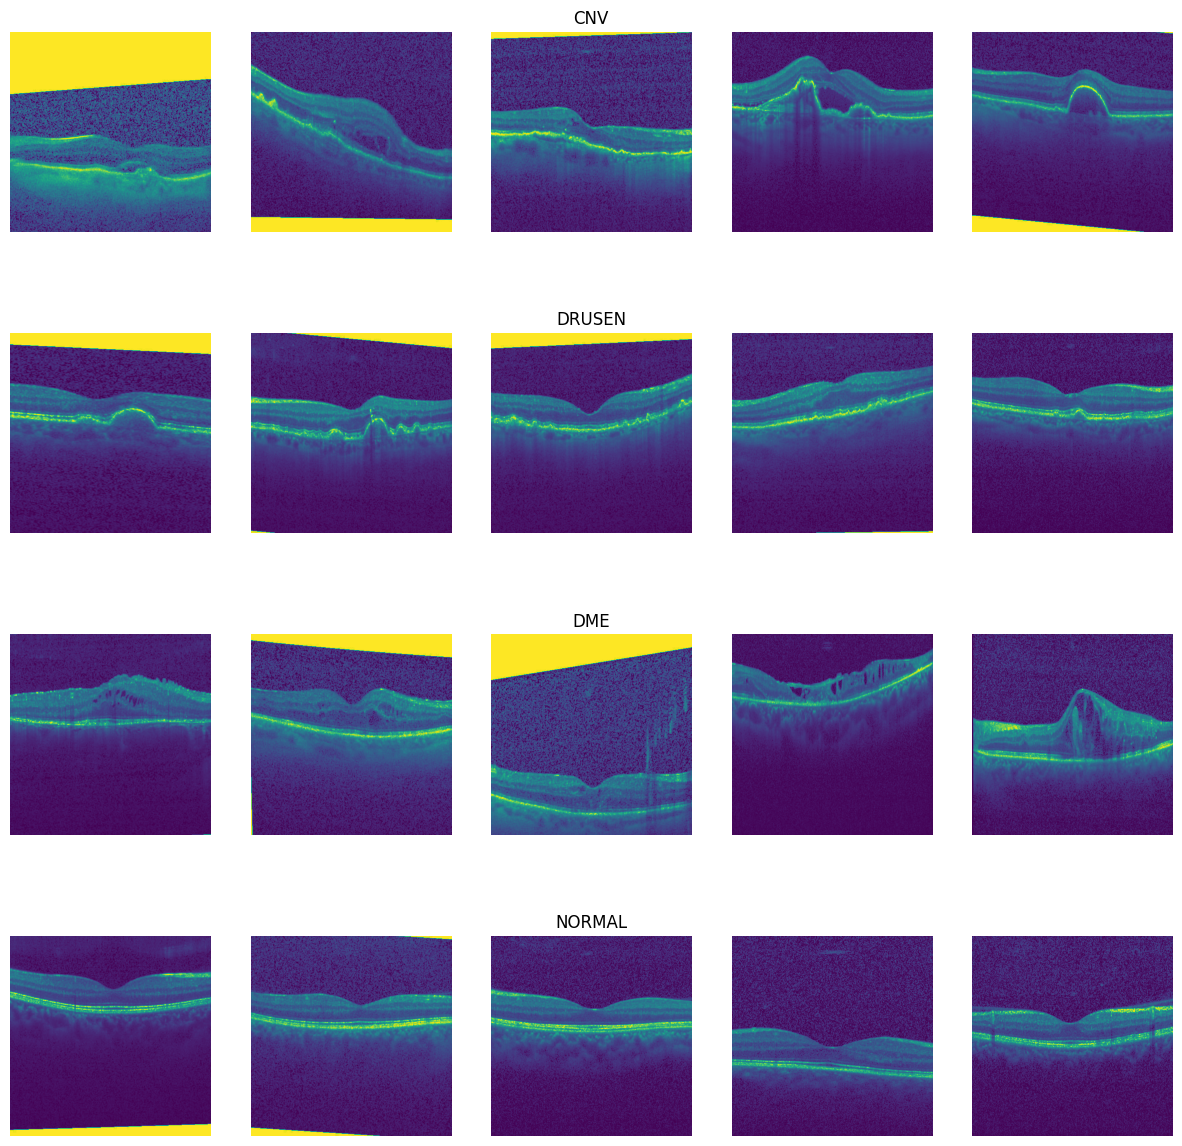

In [117]:
plot_example_images(image_paths, labels, class_distribution)

In [118]:
from tensorflow.keras import datasets, layers, models
import tensorflow as tf
import cv2 as cv


In [119]:
!ls dataset

'Dataset - train+val+test'   test   train   val


In [120]:
batchSize = 32
imageSize = (256, 256)

test_ds = tf.keras.utils.image_dataset_from_directory(directory='dataset/test', labels='inferred', label_mode='categorical', image_size=imageSize, batch_size=batchSize)
train_ds = tf.keras.utils.image_dataset_from_directory(directory='dataset/train', labels='inferred', label_mode='categorical', image_size=imageSize, batch_size=batchSize)
val_ds = tf.keras.utils.image_dataset_from_directory(directory='dataset/val', labels='inferred', label_mode='categorical', image_size=imageSize, batch_size=batchSize)

# AUTOTUNE = tf.data.AUTOTUNE

# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
# test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
model = models.Sequential([
    layers.InputLayer(input_shape=(256, 256, 3)),  # Adjust input shape as per image_size
    layers.Rescaling(1./255),  # Normalize pixel values
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')  # Ensure this matches the number of classes
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Found 10933 files belonging to 4 classes.
Found 76515 files belonging to 4 classes.
Found 21861 files belonging to 4 classes.


In [121]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 377, in dispatch_queue

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 250, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 748, in __init__

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-121-20ccbb55d66e>", line 1, in <cell line: 1>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1151, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2454, in sparse_categorical_crossentropy

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5775, in sparse_categorical_crossentropy

logits and labels must have the same first dimension, got logits shape [32,4] and labels shape [128]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_5608]

In [ ]:
plt.figure(figsize=(15, 15))
class_names = train_ds.class_names
print(class_names)
for images, labels in train_ds.take(1):
  for i in range(4):
    ax = plt.subplot(1, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[i])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)